### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import model_architectures
print(dir(model_architectures))

Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

### Loading/Visualizing Data
Functionality to load the test dataset and labels as numpy arrays and visualize any given image from the numpy array has been implemented in the model_architectures.py file for easy access.

In [4]:
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

MNIST Shape: (1, 28, 28)
MNIST Label: 2


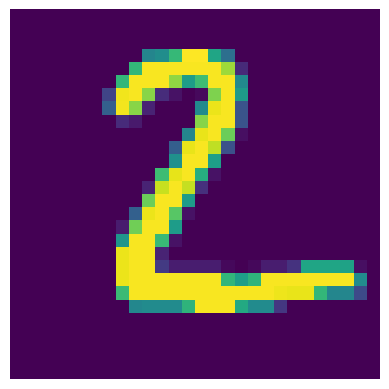


CIFAR-10 Shape: (3, 32, 32)
CIFAR-10 Label: ship


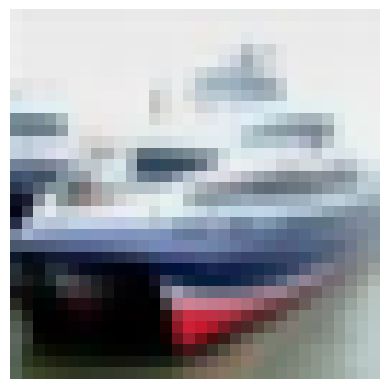


SVHN Shape: (3, 32, 32)
SVHN Label: 2


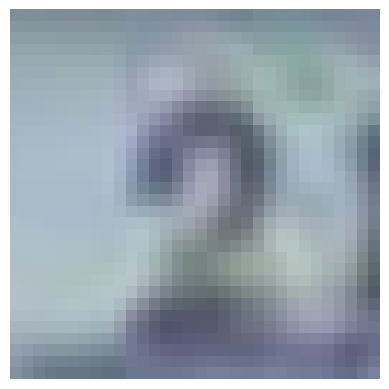

In [5]:
# Test visualizer with an image available in test data
viz = Visualizer()
# MNIST
i = 1
print(f"MNIST Shape: {mnist_test_images[i].shape}")
print(f"MNIST Label: {mnist_test_labels[i]}")
viz.show(mnist_test_images[i])

# CIFAR-10
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
print(f"\nCIFAR-10 Shape: {cifar10_test_images[i].shape}")
print(f"CIFAR-10 Label: {label_mapping[cifar10_test_labels[i]]}")
viz.show(cifar10_test_images[i])

# SVHN
print(f"\nSVHN Shape: {svhn_test_images[i].shape}")
print(f"SVHN Label: {svhn_test_labels[i]}")
viz.show(svhn_test_images[i])


### Testing our models
The data is converted to PyTorch tensors and loaded with a Data Loader for the model to be evaluated. The model can only take in Data Loaders to iterate through the data so after perturbations, we have to load it with the data loader and then evaluate the model.

In [6]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images, mnist_test_labels)
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images, cifar10_test_labels)
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images, svhn_test_labels)
tester = Tester()

In [7]:

acc_mnist = tester.test(mnist_resnet_model, test_loader_mnist)
print(f'Test Accuracy MNIST: {acc_mnist * 100:.2f}%')

Test Accuracy MNIST: 99.30%


In [8]:
acc_cifar10 = tester.test(cifar_resnet_model, test_loader_cifar10)
print(f'Test Accuracy CIFAR10: {acc_cifar10 * 100:.2f}%')

Test Accuracy CIFAR10: 76.27%


In [9]:
acc_svhn = tester.test(svhn_resnet_model, test_loader_svhn)
print(f'Test Accuracy SVHN: {acc_svhn * 100:.2f}%')

Test Accuracy SVHN: 93.07%


### Perturbing an Image and Testing Accuracy
As a simple test we'll just flip the image so it's reversed. In this process we use perturb to modify the images and then reload it with a Data Loader and test it against our model.


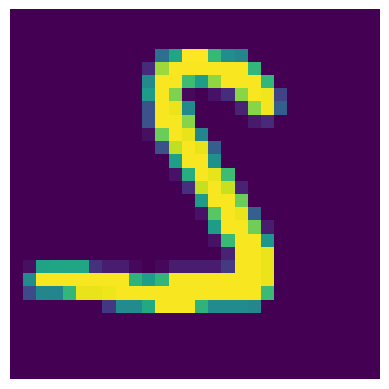

Test Accuracy MNIST (Flipped): 43.81%


In [11]:
def perturb(images):
    """
    Flip images along the specified axis.

    Parameters:
    - images: numpy array with shape (num_images, channels, height, width)
    - axis: Axis along which to flip the images (0 for vertical, 1 for horizontal)

    Returns:
    - Perturbed images
    """
    flip_axis = 1

    perturbed_images = np.empty_like(images)
    for i in range(images.shape[0]):
        perturbed_image = np.flip(images[i, 0, :, :], axis=flip_axis)
        perturbed_images[i, 0, :, :] = perturbed_image
    return perturbed_images


flipped_images_array = perturb(mnist_test_images)
# Show example of the image after being flipped
viz.show(flipped_images_array[1])

flipped_images_tensor = loader.convert_mnist_numpy_to_tensor(flipped_images_array, mnist_test_labels)

acc_mnist_flipped = tester.test(mnist_resnet_model, flipped_images_tensor)
print(f'Test Accuracy MNIST (Flipped): {acc_mnist_flipped * 100:.2f}%')
# Accuracy drops 50%